In [1]:
from optparse import OptionParser
import json
import bioframe as bf
import numpy as np
import pandas as pd
import os
from akita_utils.tsv_utils import (
    filter_by_chrmlen,
    filter_by_overlap_num,
    filter_by_chromID,
)
from akita_utils.format_io import read_jaspar_to_numpy, read_rmsk

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
jaspar_file = "/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz"
ctcf_filter_expand_window = 60
rmsk_file = "/project/fudenber_735/genomes/mm10/database/rmsk.txt.gz"
rmsk_filter_expand_window = 20
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
autosomes_only = True

if autosomes_only:
    chromID_to_drop = ["chrX", "chrY", "chrM"]

seq_length = 1310720

In [3]:
jaspar_df = bf.read_table(jaspar_file, schema="jaspar", skiprows=1)
if autosomes_only:
    jaspar_df = filter_by_chromID(jaspar_df, chrID_to_drop=chromID_to_drop)
jaspar_df.reset_index(drop=True, inplace=True)

In [4]:
# read rmsk file
rmsk_df = read_rmsk(rmsk_file)

## Boundaries

In [5]:
boundaries_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation"
boundaries = pd.read_csv(boundaries_file, sep="\t")

In [6]:
window_size = boundaries_file.split("window_")[1].split(".")[0]
boundary_key, insulation_key = (
    f"boundary_strength_{window_size}",
    f"log2_insulation_score_{window_size}",
)

In [7]:
boundary_strength_thresh = 0.25
boundary_insulation_thresh = 0

In [8]:
boundaries = boundaries.iloc[
        (boundaries[boundary_key].values > boundary_strength_thresh)
        * (
            boundaries[insulation_key].values
            < boundary_insulation_thresh
        )
    ]

In [9]:
if autosomes_only:
    boundaries = filter_by_chromID(boundaries, chrID_to_drop=chromID_to_drop)

boundaries = filter_by_chrmlen(
    boundaries,
    chrom_sizes_file,
    seq_length,
)

boundaries.reset_index(drop=True, inplace=True)

## CTCFs overlapping boundaries

In [10]:
# overlapping CTCF df with boundaries df
df_overlap = bf.overlap(
    boundaries, jaspar_df, suffixes=("", "_2"), return_index=False
)

# removing rows with no start and end info
df_overlap = df_overlap[pd.notnull(df_overlap["start_2"])]
df_overlap = df_overlap[pd.notnull(df_overlap["end_2"])]

df_overlap["span"] = (
    df_overlap["start"].astype(str) + "-" + df_overlap["end"].astype(str)
)

df_keys = [
    "chrom",
    "start_2",
    "end_2",
    "span",
    "score_2",
    "strand_2",
    insulation_key,
    boundary_key,
]

df_overlap = df_overlap[df_keys]

In [11]:
# renaming
df_overlap = df_overlap.rename(
    columns={
        "span": "boundary_span",
        "score_2": "jaspar_score",
        "start_2": "start",
        "end_2": "end",
        "strand_2": "strand",
    }
)

# filtering by CTCF
B_filtered_df = filter_by_overlap_num(
    df_overlap,
    filter_df=jaspar_df,
    expand_window=ctcf_filter_expand_window,
    max_overlap_num=1,
)

# filtering by rmsk
B_filtered_df = filter_by_overlap_num(
    B_filtered_df,
    rmsk_df,
    expand_window=rmsk_filter_expand_window,
    working_df_cols=["chrom", "start", "end"],
)

In [12]:
len(B_filtered_df)

7560

In [13]:
B_filtered_df

,chrom,start,end,boundary_span,jaspar_score,strand,log2_insulation_score_200000,boundary_strength_200000
0,chr1,4403267,4403286,4400000-4410000,803.0,-,-0.425816,1.013374
1,chr1,4770055,4770074,4770000-4780000,974.0,+,-0.489156,1.002922
2,chr1,4770180,4770199,4770000-4780000,833.0,-,-0.489156,1.002922
3,chr1,4770867,4770886,4770000-4780000,816.0,+,-0.489156,1.002922
4,chr1,4773435,4773454,4770000-4780000,815.0,+,-0.489156,1.002922
...,...,...,...,...,...,...,...,...
7555,chr19,59388426,59388445,59380000-59390000,804.0,+,-0.746354,1.189257
7556,chr19,59388676,59388695,59380000-59390000,851.0,-,-0.746354,1.189257
7557,chr19,59389390,59389409,59380000-59390000,961.0,+,-0.746354,1.189257
7558,chr19,59770157,59770176,59770000-59780000,809.0,-,-0.061002,0.369792


In [16]:
boundary_ctcf_counts = B_filtered_df.groupby('boundary_span').size()

In [17]:
min_ctcf_sites = boundary_ctcf_counts.min()
max_ctcf_sites = boundary_ctcf_counts.max()
avg_ctcf_sites = boundary_ctcf_counts.mean()
median_ctcf_sites = boundary_ctcf_counts.median()

print(f"Minimum CTCF sites per boundary: {min_ctcf_sites}")
print(f"Maximum CTCF sites per boundary: {max_ctcf_sites}")
print(f"Average CTCF sites per boundary: {avg_ctcf_sites}")
print(f"Median CTCF sites per boundary: {median_ctcf_sites}")

Minimum CTCF sites per boundary: 1
Maximum CTCF sites per boundary: 15
Average CTCF sites per boundary: 2.7019299499642604
Median CTCF sites per boundary: 2.0


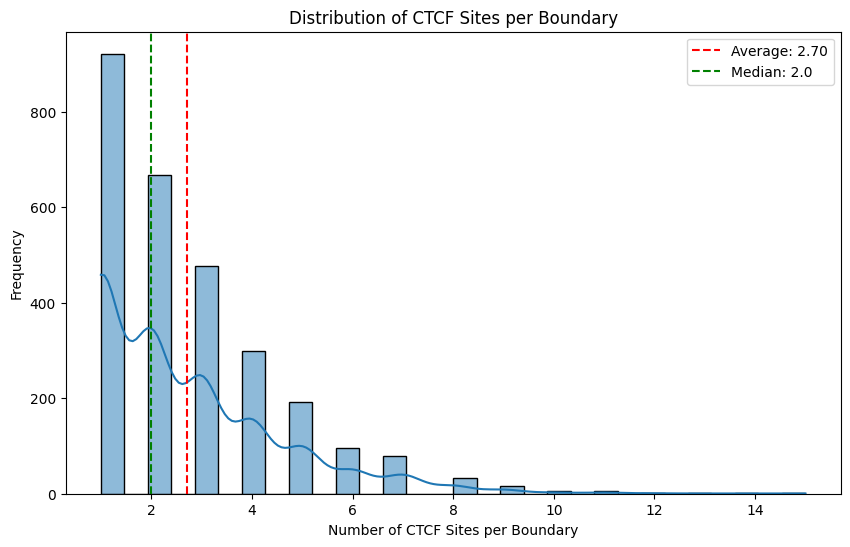

In [20]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(boundary_ctcf_counts, bins=30, kde=True)
plt.title('Distribution of CTCF Sites per Boundary')
plt.xlabel('Number of CTCF Sites per Boundary')
plt.ylabel('Frequency')
plt.axvline(avg_ctcf_sites, color='r', linestyle='--', label=f'Average: {avg_ctcf_sites:.2f}')
plt.axvline(median_ctcf_sites, color='g', linestyle='--', label=f'Median: {median_ctcf_sites}')
plt.legend()
plt.show()

In [21]:
# Calculate the percentages
total_boundaries = len(boundary_ctcf_counts)
more_than_6 = (boundary_ctcf_counts > 6).sum()
more_than_10 = (boundary_ctcf_counts > 10).sum()

percent_more_than_6 = (more_than_6 / total_boundaries) * 100
percent_more_than_10 = (more_than_10 / total_boundaries) * 100

In [22]:
print(f"Percentage of boundaries with more than 6 CTCF sites: {percent_more_than_6:.2f}%")
print(f"Percentage of boundaries with more than 10 CTCF sites: {percent_more_than_10:.2f}%")

Percentage of boundaries with more than 6 CTCF sites: 5.11%
Percentage of boundaries with more than 10 CTCF sites: 0.36%
